# Defect detection in aluminum castings using YOLOv3

Example using series C0001 of [GDXray](https://domingomery.ing.puc.cl/material/gdxray/). Training and validation using simulated ellipsoidal defects only. Testing on real defects only. Training, Validation and Testing images belong to the same type of wheel. The idea is to demonstrate that we can inspect a type of wheel if we train using the images of this wheel with no defects + simulated defects and test the model on X-ray images of the same type of wheel with real defects.

This example is based on YOLOv3 Tutorial from original GitHub (https://github.com/ultralytics/yolov3)





# Environment Setup
Download and install in Colab required packages and import libraries.

In [4]:
import time
import glob
import torch
import os

from IPython.display import Image, clear_output 
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

!git clone https://github.com/ultralytics/yolov3  # clone
%cd yolov3

PyTorch 1.6.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)
Cloning into 'yolov3'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 9405 (delta 1), reused 5 (delta 1), pack-reused 9399
Receiving objects: 100% (9405/9405), 7.79 MiB | 27.24 MiB/s, done.
Resolving deltas: 100% (6451/6451), done.
/content/trash/__MACOSX/yolov3/yolov3


# Download casting data

Training, validation and testing images and annotations of series C0001 of GDXray.

In [5]:
# Download training images and annotations
!wget https://www.dropbox.com/s/hjfbghm53oe7uw9/cast.zip
!unzip cast.zip
!rm cast.zip
!mv ./cast ../  # move folder alongside /yolov5
!cp ../cast/castval.txt ../cast/castvalbak.txt     # copy of validation set
!cp ../cast/casttest.txt ../cast/casttestbak.txt   # copy of testing set
!mv ../cast/cast.data data/cast.data
!mv ../cast/cast.names data/cast.names
!mv ../cast/yolov3-spp-my.cfg cfg/yolov3-spp-my.cfg
clear_output()
print('cast.zip unzipped and copied, annotations and config file moved to correspondg directory.')



cast.zip unzipped and copied, annotations and config file moved to correspondg directory.


# Setup training parameters

Select model of YOLOv5, number of epochs, batchs, etc.

After this, run `train.py` to train YOLOv3-SPP starting from a darknet53 backbone.

File yolov3-spp-my.cfg has been configured according to https://github.com/ultralytics/yolov3/wiki/Example:-Train-Single-Class

In [7]:
ytype = 1 # 1 for YOLOv3-tiny, 2 for YOLOv3-spp
ynew  = 1 # 1 for new training using YOLOv3 pretrained weights, 0 for last weights computed after training
# first run must be with ynew = 1, second run could be with ynew = 0 using last weights (to continue the training with additional epochs)

if ytype:
  CFG = 'yolov3-tiny3-1cls.cfg'
  TRAIN_WEIGHTS = 'yolov3-tiny.pt'
else:
  CFG = 'yolov3-spp-my.cfg'
  TRAIN_WEIGHTS = 'yolov3-spp-ultralytics.pt'


if ynew == 0:
  TRAIN_WEIGHTS  = 'weights/last.pt'

EPOCHS = 50


# Training

YOLOv3 model will be trained according setup of last cell using model {ytype}, ie if ytype is 1, then model YOLOv3-tiny will be trained.

In [8]:
# training validating with validation set
# the validation set using in this training is defined castval.txt 
!cp ../cast/castvalbak.txt ../cast/castval.txt
!python3 train.py --cfg {CFG} --data data/cast.data --img-size 640 --epochs {EPOCHS} --nosave --weights {TRAIN_WEIGHTS}

Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
Namespace(adam=False, batch_size=16, bucket='', cache_images=False, cfg='./cfg/yolov3-tiny3-1cls.cfg', data='data/cast.data', device='', epochs=50, evolve=False, freeze_layers=False, img_size=[640], multi_scale=False, name='', nosave=True, notest=False, rect=False, resume=False, single_cls=False, weights='yolov3-tiny.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/
2020-08-10 18:19:33.891327: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Model Summary: 45 layers, 9.00039e+06 parameters, 9.00039e+06 gradients
Optimizer groups: 16 .bias, 16 Conv2d.weight, 13 other
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent

# Evaluation of Performance

In [9]:
#mAP in validation set (mPA is computef for the images stored in castval.txt)
!cp ../cast/castvalbak.txt ../cast/castval.txt
!python test.py  --weights weights/last.pt --cfg {CFG} --img-size 640 --conf-thres 0.2 --iou-thres 0.5 --data data/cast.data --task test

Namespace(augment=False, batch_size=16, cfg='./cfg/yolov3-tiny3-1cls.cfg', conf_thres=0.2, data='data/cast.data', device='', img_size=640, iou_thres=0.5, save_json=False, single_cls=False, task='test', weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Model Summary: 45 layers, 9.00039e+06 parameters, 9.00039e+06 gradients
Fusing layers...
Model Summary: 32 layers, 8.99695e+06 parameters, 8.99695e+06 gradients
Caching labels ../cast/labels/val.npy (1440 found, 0 missing, 0 empty, 0 duplicate, for 1440 images): 100% 1440/1440 [00:00<00:00, 12327.55it/s]
               Class    Images   Targets         P         R   mAP@0.5        F1:   0% 0/90 [00:00<?, ?it/s]test.py:148: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  ti = (cls == tcls_tens

In [10]:
#mAP in testing set (mPA is computef for the images stored in castval.txt, for this reason we copy casttextbak into castval.txt)
!cp ../cast/casttestbak.txt ../cast/castval.txt
!python test.py  --weights weights/last.pt --cfg {CFG} --img-size 640 --conf-thres 0.2 --iou-thres 0.5 --data data/cast.data --task test

Namespace(augment=False, batch_size=16, cfg='./cfg/yolov3-tiny3-1cls.cfg', conf_thres=0.2, data='data/cast.data', device='', img_size=640, iou_thres=0.5, save_json=False, single_cls=False, task='test', weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Model Summary: 45 layers, 9.00039e+06 parameters, 9.00039e+06 gradients
Fusing layers...
Model Summary: 32 layers, 8.99695e+06 parameters, 8.99695e+06 gradients
Reading image shapes: 100% 720/720 [00:00<00:00, 9192.35it/s]
Caching labels ../cast/castval.txt (419 found, 301 missing, 0 empty, 0 duplicate, for 720 images): 100% 720/720 [00:00<00:00, 8968.87it/s]
               Class    Images   Targets         P         R   mAP@0.5        F1:   0% 0/45 [00:00<?, ?it/s]test.py:148: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/ut

# Detection of Bounding boxes in testing images

In [11]:
!python detect.py --weights weights/last.pt --img 640 --names data/cast.names --cfg {CFG} --conf-thres 0.35 --source ../cast/images/test/ --save-txt

Namespace(agnostic_nms=False, augment=False, cfg='./cfg/yolov3-tiny3-1cls.cfg', classes=None, conf_thres=0.35, device='', fourcc='mp4v', half=False, img_size=640, iou_thres=0.6, names='data/cast.names', output='output', save_txt=True, source='../cast/images/test/', view_img=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Model Summary: 45 layers, 9.00039e+06 parameters, 9.00039e+06 gradients
image 1/720 ../cast/images/test/C0001_0001_01.jpg: 640x640 2 defects, Done. (0.005s)
image 2/720 ../cast/images/test/C0001_0001_02.jpg: 640x640 2 defects, Done. (0.005s)
image 3/720 ../cast/images/test/C0001_0001_03.jpg: 640x640 1 defects, Done. (0.005s)
image 4/720 ../cast/images/test/C0001_0001_04.jpg: 640x640 1 defects, Done. (0.005s)
image 5/720 ../cast/images/test/C0001_0001_05.jpg: 640x640 4 defects, Done. (0.005s)
image 6/720 ../cast/images/test/C0001_0001_06.jpg: 640x640 2 defects, Done. (0.005s)
image 7/720 ../c

# Visualization & Backup

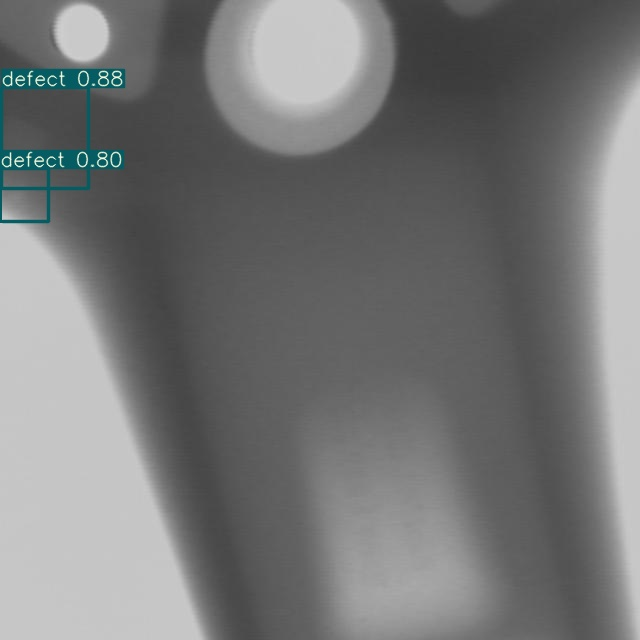

In [12]:
Image(filename='output/C0001_0024_03.jpg', width=600)

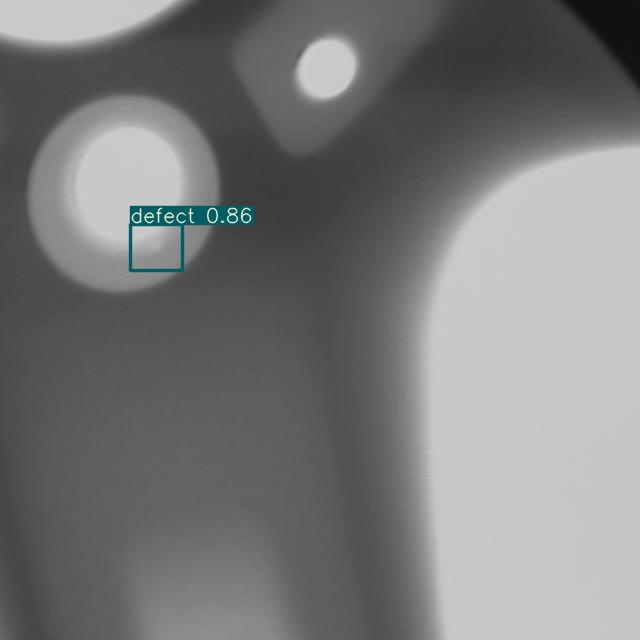

In [13]:
Image(filename='output/C0001_0053_05.jpg', width=600)

In [14]:
# Backup of images with bounding boxes
!zip -r test_detection zip output/
clear_output()
print('output images zipped in file test_detection.zip')


output images zipped in file test_detection.zip


In [ ]:
# DOWNLOAD RESULTS FROM test_detection.zip

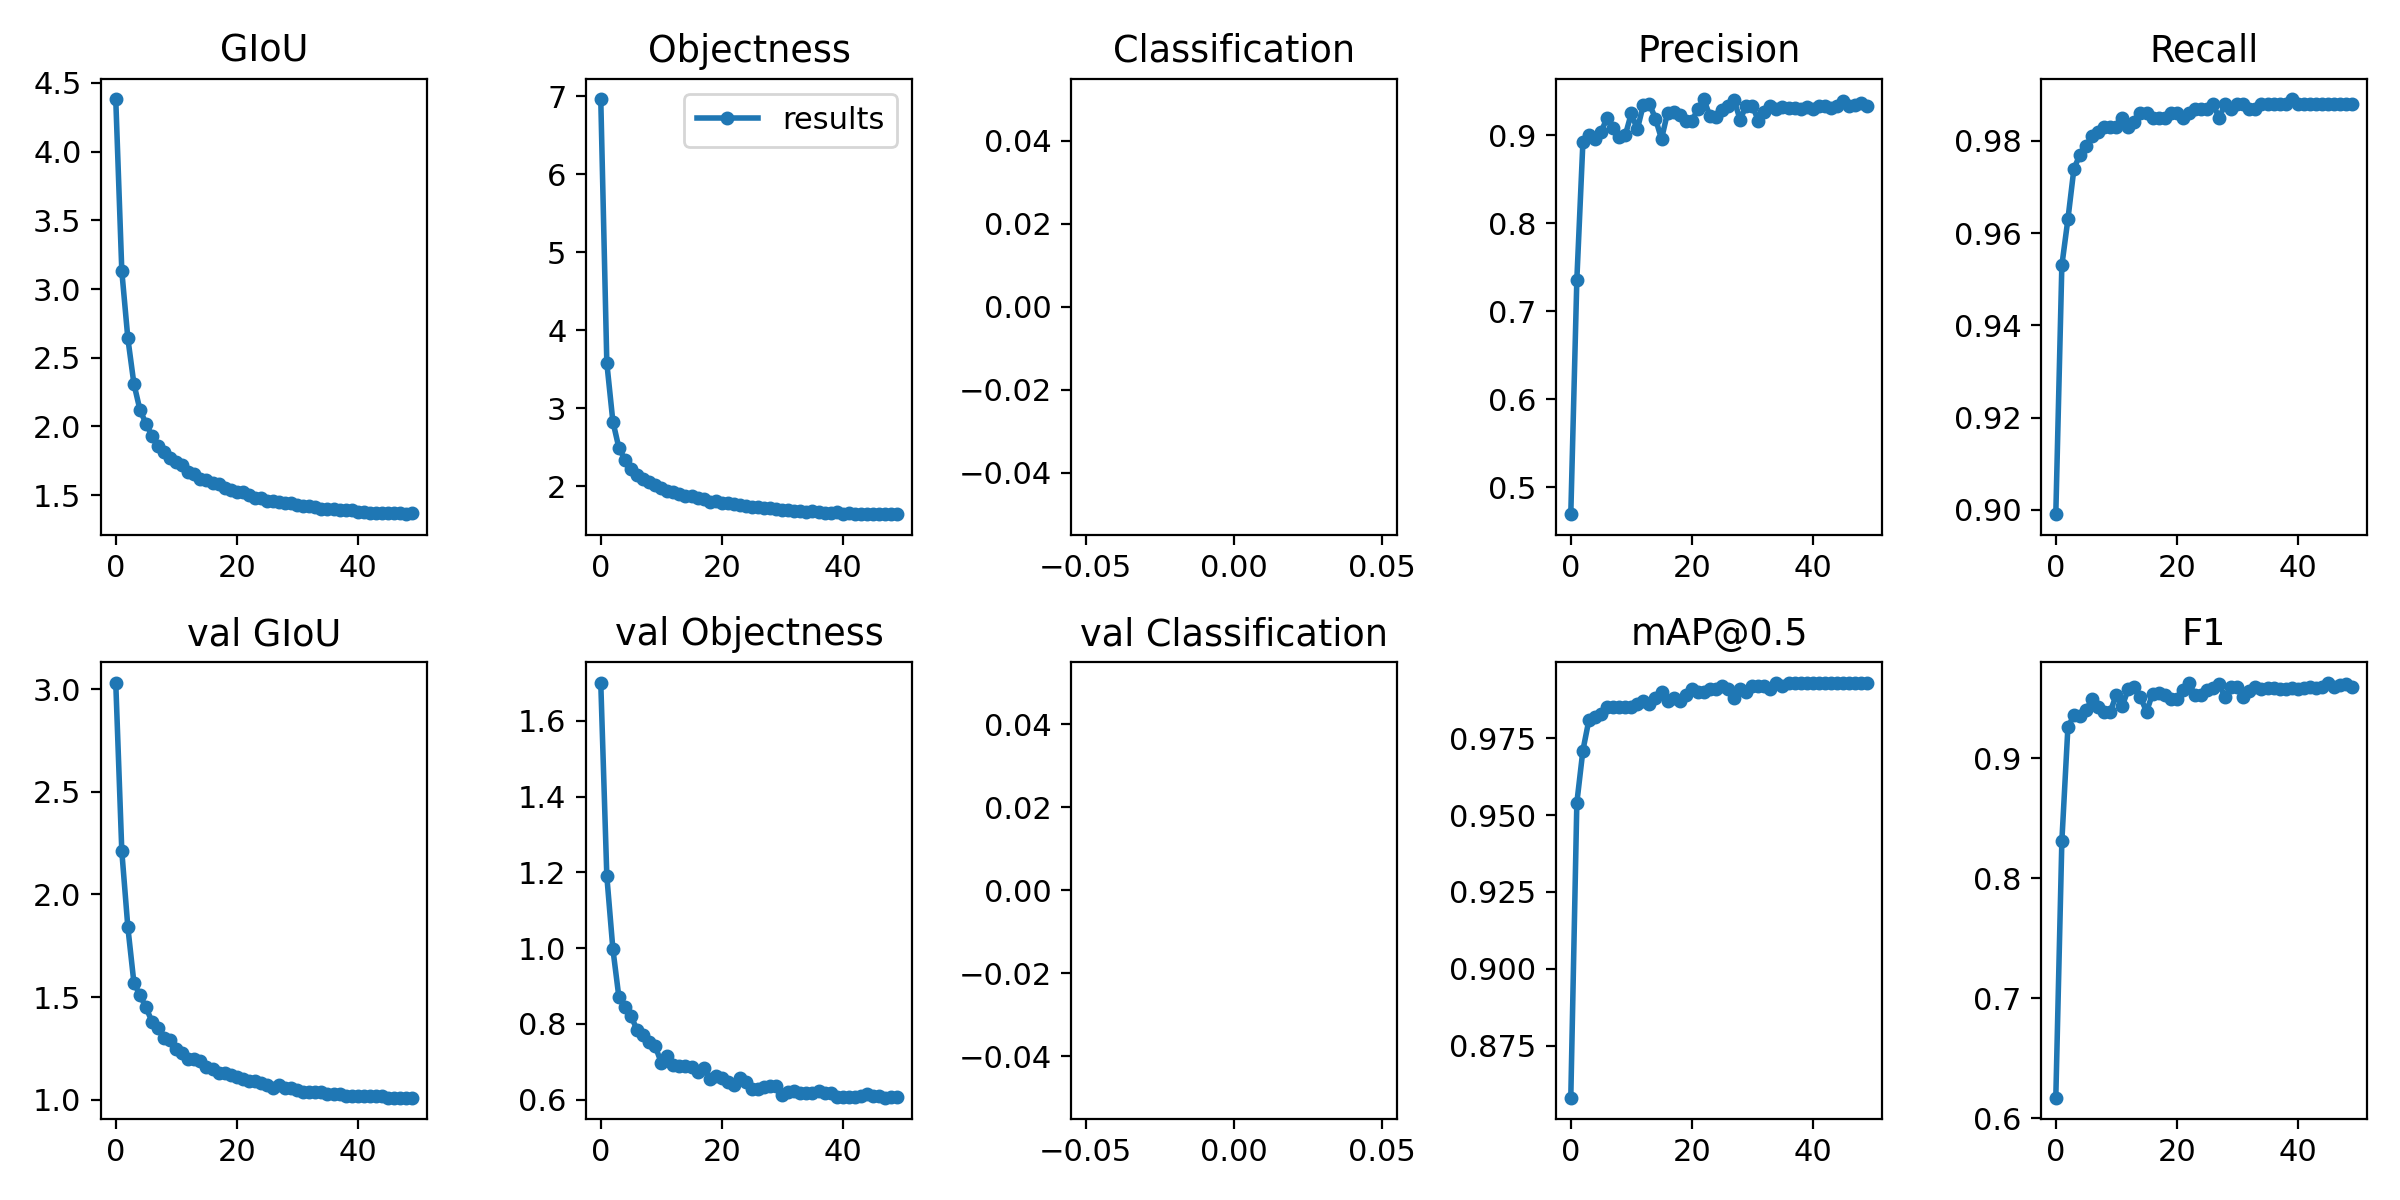

In [15]:
Image(filename='results.png', width=600)